In [1]:
# Importar librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, roc_auc_score
)

# Clasificadores
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# TensorFlow y Keras    
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configuración de visualización
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")
sns.set_palette("husl")

2025-12-01 22:29:26.040245: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 1. Cargar Características Extraídas
Cargamos las características guardadas en el notebook anterior.

In [2]:
# Cargar datos
RESULTS_DIR = Path("../results")
data = np.load(RESULTS_DIR / "features_classical.npz")

X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']
X_val = data['X_val']
y_val = data['y_val']

print("=== DATOS CARGADOS ===")
print(f"Train: {X_train.shape}")
print(f"Test:  {X_test.shape}")
print(f"Val:   {X_val.shape}")
print(f"\nDistribución de clases (Train):")
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    clase = "NORMAL" if u == 0 else "PNEUMONIA"
    print(f"  {clase}: {c} ({c/len(y_train)*100:.1f}%)")

=== DATOS CARGADOS ===
Train: (1000, 54827)
Test:  (624, 54827)
Val:   (16, 54827)

Distribución de clases (Train):
  NORMAL: 500 (50.0%)
  PNEUMONIA: 500 (50.0%)


### 2. Normalización de Características
Dado que las características tienen diferentes escalas, normalizamos usando StandardScaler.

In [3]:
# Verificar y limpiar datos antes de normalizar
print("🔍 Verificando calidad de los datos...")
print(f"NaN en X_train: {np.isnan(X_train).sum()}")
print(f"Inf en X_train: {np.isinf(X_train).sum()}")
print(f"Valores muy grandes (>1e10): {(np.abs(X_train) > 1e10).sum()}")

# Reemplazar NaN e Inf con valores válidos
X_train_clean = np.nan_to_num(X_train, nan=0.0, posinf=1e10, neginf=-1e10)
X_test_clean = np.nan_to_num(X_test, nan=0.0, posinf=1e10, neginf=-1e10)
X_val_clean = np.nan_to_num(X_val, nan=0.0, posinf=1e10, neginf=-1e10)

print(f"\n✅ Datos limpiados")
print(f"NaN después de limpieza: {np.isnan(X_train_clean).sum()}")
print(f"Inf después de limpieza: {np.isinf(X_train_clean).sum()}")

# Normalización con StandardScaler (media=0, std=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_clean)
X_test_scaled = scaler.transform(X_test_clean)
X_val_scaled = scaler.transform(X_val_clean)

print("\n✅ Datos normalizados")
print(f"Media del train escalado: {X_train_scaled.mean():.6f}")
print(f"Std del train escalado: {X_train_scaled.std():.6f}")

🔍 Verificando calidad de los datos...
NaN en X_train: 0
Inf en X_train: 0
Valores muy grandes (>1e10): 0

✅ Datos limpiados
NaN después de limpieza: 0
Inf después de limpieza: 0

✅ Datos normalizados
Media del train escalado: 0.000000
Std del train escalado: 1.000000


In [4]:
# Normalización con MinMaxScaler (0-1)
minmax_scaler = MinMaxScaler()
X_train_minmax = minmax_scaler.fit_transform(X_train_clean)
X_test_minmax = minmax_scaler.transform(X_test_clean)
X_val_minmax = minmax_scaler.transform(X_val_clean)

print("\n✅ Datos normalizados con MinMaxScaler")
print(f"Min del train minmax: {X_train_minmax.min():.6f}")
print(f"Max del train minmax: {X_train_minmax.max():.6f}")


✅ Datos normalizados con MinMaxScaler
Min del train minmax: 0.000000
Max del train minmax: 1.000000


### 3. Reducción de Dimensionalidad
Exploramos PCA para reducir dimensiones y visualizar la separabilidad de clases.

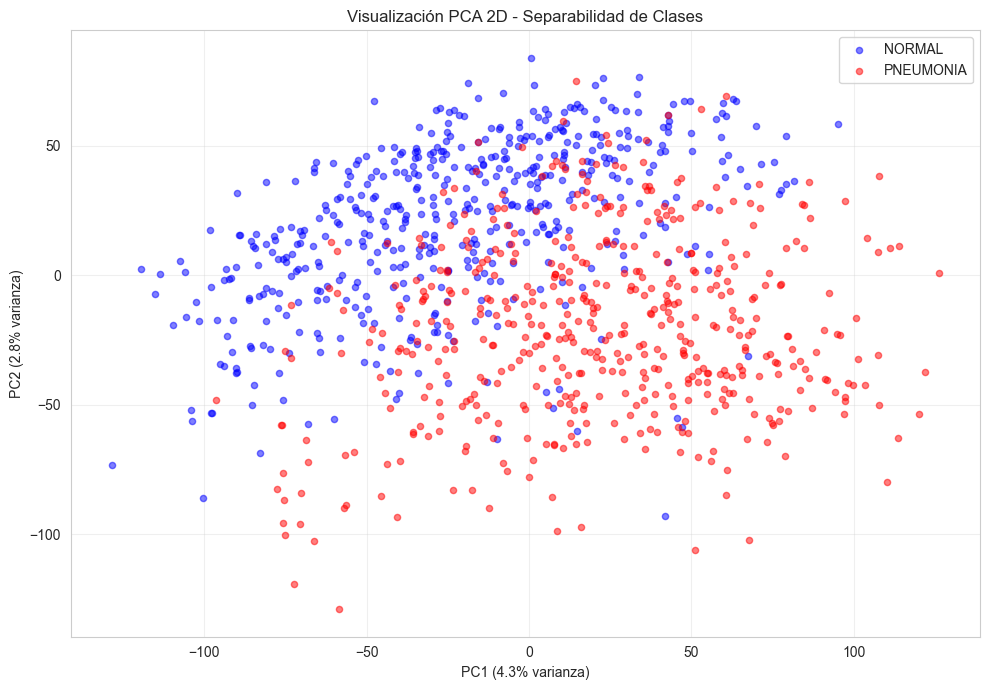


Varianza explicada por las primeras 2 componentes: 7.11%
✅ Imagen guardada: results/figures/09_pca_2d_visualization.png


In [5]:
# PCA para visualización
pca_vis = PCA(n_components=2)
X_train_pca2d = pca_vis.fit_transform(X_train_scaled)

# Visualizar en 2D
plt.figure(figsize=(10, 7))
colors = ['blue', 'red']
labels = ['NORMAL', 'PNEUMONIA']

for i, (color, label) in enumerate(zip(colors, labels)):
    mask = y_train == i
    plt.scatter(
        X_train_pca2d[mask, 0],
        X_train_pca2d[mask, 1],
        c=color,
        label=label,
        alpha=0.5,
        s=20
    )

plt.xlabel(f'PC1 ({pca_vis.explained_variance_ratio_[0]*100:.1f}% varianza)')
plt.ylabel(f'PC2 ({pca_vis.explained_variance_ratio_[1]*100:.1f}% varianza)')
plt.title('Visualización PCA 2D - Separabilidad de Clases')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/figures/09_pca_2d_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nVarianza explicada por las primeras 2 componentes: {pca_vis.explained_variance_ratio_.sum()*100:.2f}%")
print("✅ Imagen guardada: results/figures/09_pca_2d_visualization.png")

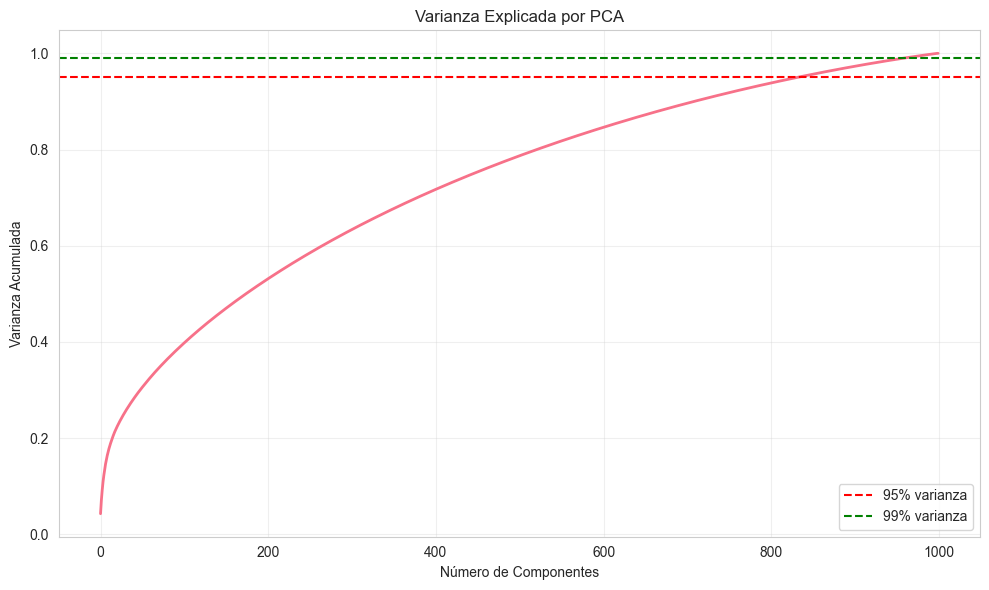


Componentes necesarias para 95% varianza: 832
Componentes necesarias para 99% varianza: 959
✅ Imagen guardada: results/figures/10_pca_variance_explained.png


In [7]:
# Análisis de componentes principales óptimas
pca_full = PCA()
pca_full.fit(X_train_scaled)

# Gráfica de varianza acumulada
cumsum_variance = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(cumsum_variance, linewidth=2)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% varianza')
plt.axhline(y=0.99, color='g', linestyle='--', label='99% varianza')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada')
plt.title('Varianza Explicada por PCA')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/figures/10_pca_variance_explained.png', dpi=150, bbox_inches='tight')
plt.show()

# Número de componentes para 95% y 99% de varianza
n_comp_95 = np.argmax(cumsum_variance >= 0.95) + 1
n_comp_99 = np.argmax(cumsum_variance >= 0.99) + 1

print(f"\nComponentes necesarias para 95% varianza: {n_comp_95}")
print(f"Componentes necesarias para 99% varianza: {n_comp_99}")
print("✅ Imagen guardada: results/figures/10_pca_variance_explained.png")

### 4. Entrenamiento de Clasificadores
Entrenamos y comparamos múltiples clasificadores con validación cruzada estratificada.

Debido al costo computacional, la CNN se evaluó mediante un esquema train/valid/test, mientras que los clasificadores clásicos utilizaron validación cruzada estratificada 5-fold.

=== VALIDACIÓN CRUZADA (5-Fold) ===

Entrenando clasificadores...

  Logistic Regression... F1-Score: 0.9540 (+/- 0.0089)
  SVM (Linear)... F1-Score: 0.9628 (+/- 0.0092)
  SVM (RBF)... F1-Score: 0.9625 (+/- 0.0120)
  Random Forest... F1-Score: 0.9057 (+/- 0.0254)
  k-NN (k=5)... F1-Score: 0.9050 (+/- 0.0109)


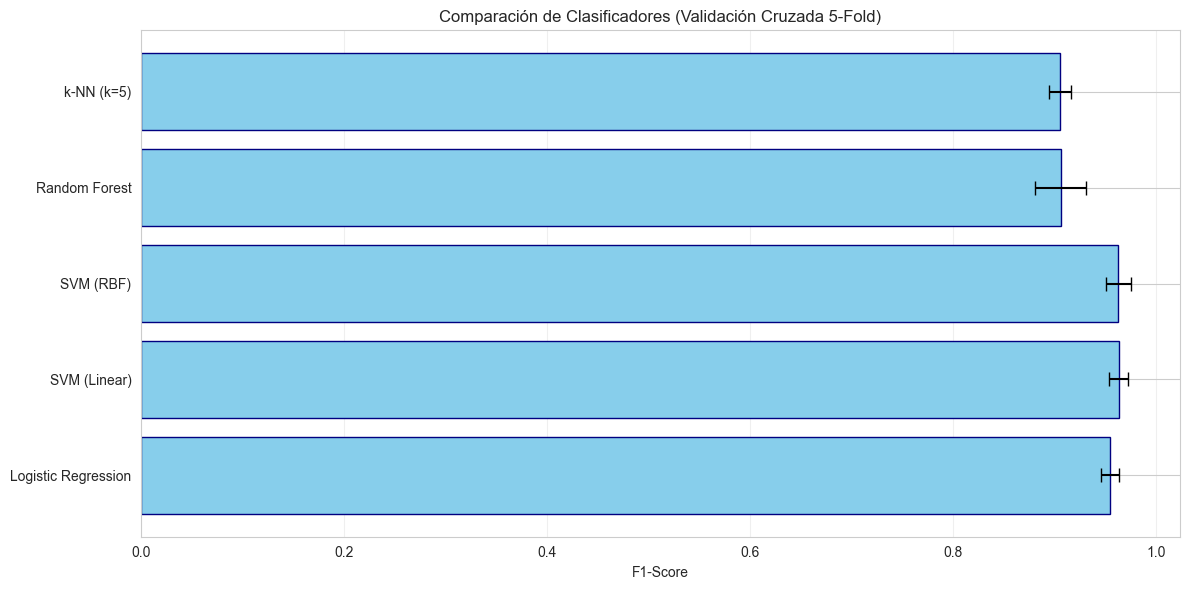


✅ Imagen guardada: results/figures/11_cv_comparison.png


In [9]:
# Configurar validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Definir clasificadores
clasificadores = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM (Linear)': SVC(kernel='linear', probability=True, random_state=42),
    'SVM (RBF)': SVC(kernel='rbf', probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'k-NN (k=5)': KNeighborsClassifier(n_neighbors=5),
}

# Almacenar resultados
resultados_cv = {}

print("=== VALIDACIÓN CRUZADA (5-Fold) ===")
print("\nEntrenando clasificadores...\n")

for nombre, clf in clasificadores.items():
    print(f"  {nombre}...", end=' ')
    
    # Validación cruzada
    scores = cross_val_score(clf, X_train_scaled, y_train, cv=cv, scoring='f1')
    
    resultados_cv[nombre] = {
        'mean': scores.mean(),
        'std': scores.std(),
        'scores': scores
    }
    
    print(f"F1-Score: {scores.mean():.4f} (+/- {scores.std():.4f})")

# Visualizar resultados de CV
fig, ax = plt.subplots(figsize=(12, 6))
nombres = list(resultados_cv.keys())
medias = [resultados_cv[n]['mean'] for n in nombres]
stds = [resultados_cv[n]['std'] for n in nombres]

ax.barh(nombres, medias, xerr=stds, capsize=5, color='skyblue', edgecolor='navy')
ax.set_xlabel('F1-Score')
ax.set_title('Comparación de Clasificadores (Validación Cruzada 5-Fold)')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('../results/figures/11_cv_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Imagen guardada: results/figures/11_cv_comparison.png")

### 5. Entrenamiento Final y Evaluación en Test
Entrenamos los clasificadores en todo el conjunto de entrenamiento y evaluamos en test.

In [ ]:
# Entrenar todos los clasificadores
modelos_entrenados = {}
predicciones = {}
probabilidades = {}

print("\n=== ENTRENAMIENTO FINAL ===")
for nombre, clf in clasificadores.items():
    print(f"Entrenando {nombre}...")
    clf.fit(X_train_scaled, y_train)
    modelos_entrenados[nombre] = clf
    
    # Predicciones en test
    predicciones[nombre] = clf.predict(X_test_scaled)
    
    # Probabilidades (para curva ROC)
    if hasattr(clf, 'predict_proba'):
        probabilidades[nombre] = clf.predict_proba(X_test_scaled)[:, 1]
    elif hasattr(clf, 'decision_function'):
        probabilidades[nombre] = clf.decision_function(X_test_scaled)

print("\n✅ Todos los modelos entrenados")


=== ENTRENAMIENTO FINAL ===
Entrenando Logistic Regression...
Entrenando SVM (Linear)...
Entrenando SVM (RBF)...


### 6. Clasificación con Redes Neuronales Convolucionales (CNN)
Implementamos una CNN básica utilizando las imágenes en crudo.

In [ ]:
# Para reproducibilidad 
tf.random.set_seed(42)
np.random.seed(42)

# Configuración básica
IMG_WIDTH, IMG_HEIGHT = 150, 150
BATCH_SIZE = 32
EPOCHS = 10  

BASE_DIR = Path("../data/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray")
TRAIN_DIR = BASE_DIR / "train"
VAL_DIR   = BASE_DIR / "val"
TEST_DIR  = BASE_DIR / "test"

print("🔄 Preparando generadores de datos...")

# Generadores SOLO con reescalado (sin data augmentation para dejar el experimento reproducible)
train_datagen = ImageDataGenerator(rescale=1./255.)
val_datagen   = ImageDataGenerator(rescale=1./255.)
test_datagen  = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print("\nClases detectadas por el generador (train):", train_generator.class_indices)

# ============================
# Definición del modelo CNN
# ============================

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# ============================
# Entrenamiento
# ============================

print("\n🚀 Entrenando CNN...")
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)

print("\n✅ Entrenamiento completado")

# ============================
# Evaluación en test
# ============================

print("\n📊 Evaluando en conjunto de test...")
test_loss, test_acc = model.evaluate(test_generator, verbose=0)
print(f"Loss en test: {test_loss:.4f}")
print(f"Accuracy en test: {test_acc:.4f}")

# Predicciones en test
y_test_cnn = test_generator.classes
y_proba_cnn = model.predict(test_generator).ravel()
y_pred_cnn = (y_proba_cnn >= 0.5).astype(int)

# ============================
# Métricas clásicas
# ============================

acc_cnn = accuracy_score(y_test_cnn, y_pred_cnn)
prec_cnn = precision_score(y_test_cnn, y_pred_cnn)
rec_cnn = recall_score(y_test_cnn, y_pred_cnn)
f1_cnn = f1_score(y_test_cnn, y_pred_cnn)
auc_cnn = roc_auc_score(y_test_cnn, y_proba_cnn)

print("\n=== MÉTRICAS CNN (Test) ===")
print(f"Accuracy : {acc_cnn:.4f}")
print(f"Precision: {prec_cnn:.4f}")
print(f"Recall   : {rec_cnn:.4f}")
print(f"F1-Score : {f1_cnn:.4f}")
print(f"AUC-ROC  : {auc_cnn:.4f}")

# Informe detallado
print("\n=== Classification Report (CNN) ===")
print(classification_report(
    y_test_cnn,
    y_pred_cnn,
    target_names=['NORMAL', 'PNEUMONIA']
))

# ============================
# Matriz de confusión CNN
# ============================

cm_cnn = confusion_matrix(y_test_cnn, y_pred_cnn)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_cnn,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['NORMAL', 'PNEUMONIA'],
    yticklabels=['NORMAL', 'PNEUMONIA']
)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Matriz de Confusión - CNN')
plt.tight_layout()
plt.savefig('../results/figures/16_confusion_matrix_cnn.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Imagen guardada: results/figures/16_confusion_matrix_cnn.png")

# ============================
# Curva ROC CNN
# ============================

fpr_cnn, tpr_cnn, _ = roc_curve(y_test_cnn, y_proba_cnn)

plt.figure(figsize=(7, 6))
plt.plot(fpr_cnn, tpr_cnn, linewidth=2, label=f'CNN (AUC={auc_cnn:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Azar (AUC=0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR / Recall)')
plt.title('Curva ROC - CNN')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/figures/17_roc_cnn.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Imagen guardada: results/figures/17_roc_cnn.png")

### 7. Métricas de Evaluación
Calculamos accuracy, precision, recall, F1-score y AUC-ROC.


=== MÉTRICAS EN CONJUNTO DE PRUEBA ===
       Clasificador  Accuracy  Precision   Recall  F1-Score  AUC-ROC
         k-NN (k=5)  0.820513   0.861979 0.848718  0.855297 0.871691
Logistic Regression  0.786859   0.757515 0.969231  0.850394 0.920064
       SVM (Linear)  0.770833   0.739806 0.976923  0.841989 0.922617
      Random Forest  0.769231   0.752049 0.941026  0.835991 0.889081
          SVM (RBF)  0.759615   0.733463 0.966667  0.834071 0.909829


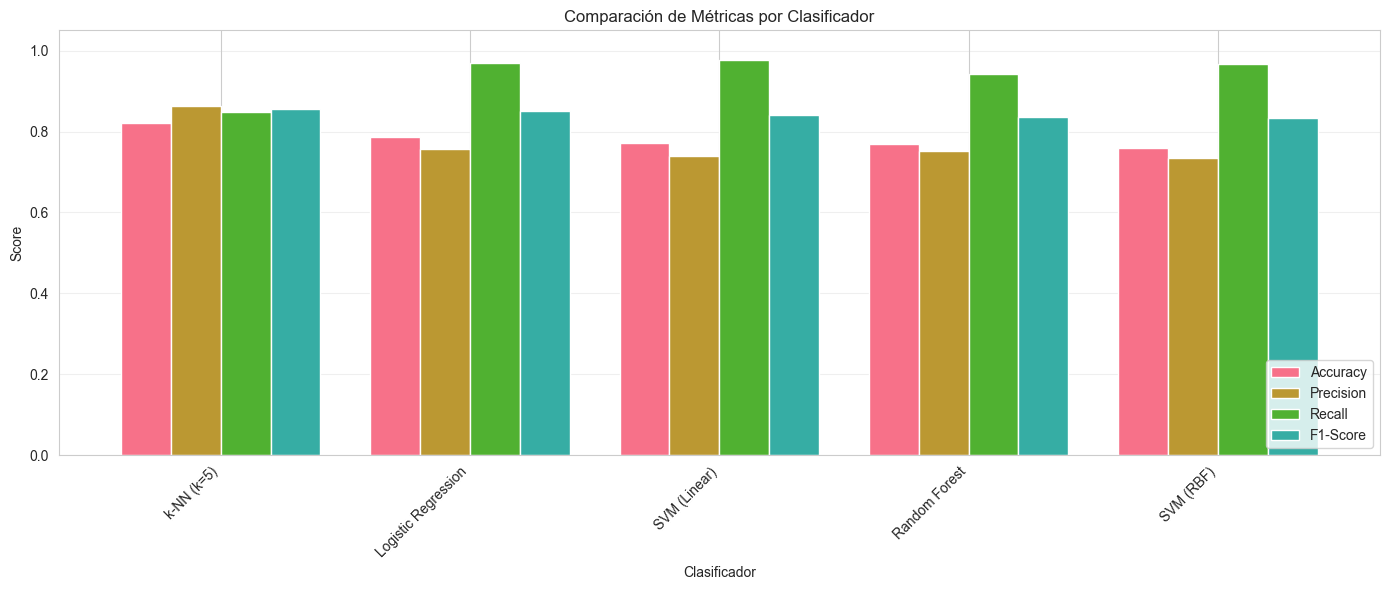


✅ Imagen guardada: results/figures/12_metrics_comparison.png


In [ ]:
# Calcular métricas
metricas = []

for nombre in clasificadores.keys():
    y_pred = predicciones[nombre]
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # AUC
    if nombre in probabilidades:
        auc = roc_auc_score(y_test, probabilidades[nombre])
    else:
        auc = None
    
    metricas.append({
        'Clasificador': nombre,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'AUC-ROC': auc
    })

# Crear DataFrame
df_metricas = pd.DataFrame(metricas)
df_metricas = df_metricas.sort_values('F1-Score', ascending=False)

#Añadimos CNN al DataFrame de métricas
nombre_cnn = "CNN (imágenes crudas)"
predicciones[nombre_cnn] = y_pred_cnn

nueva_fila = {
        'Clasificador': nombre_cnn,
        'Accuracy': acc_cnn,
        'Precision': prec_cnn,
        'Recall': rec_cnn,
        'F1-Score': f1_cnn,
        'AUC': auc_cnn
    }

df_metricas = pd.concat([df_metricas, pd.DataFrame([nueva_fila])], ignore_index=True)

print("\n=== MÉTRICAS EN CONJUNTO DE PRUEBA ===")
print(df_metricas.to_string(index=False))

# Visualización de métricas
df_plot = df_metricas.set_index('Clasificador')[['Accuracy', 'Precision', 'Recall', 'F1-Score']]

df_plot.plot(kind='bar', figsize=(14, 6), width=0.8)
plt.title('Comparación de Métricas por Clasificador')
plt.ylabel('Score')
plt.xlabel('Clasificador')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='lower right')
plt.ylim(0, 1.05)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('../results/figures/12_metrics_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Imagen guardada: results/figures/12_metrics_comparison.png")

### 8. Matrices de Confusión
Visualizamos las matrices de confusión para analizar errores.

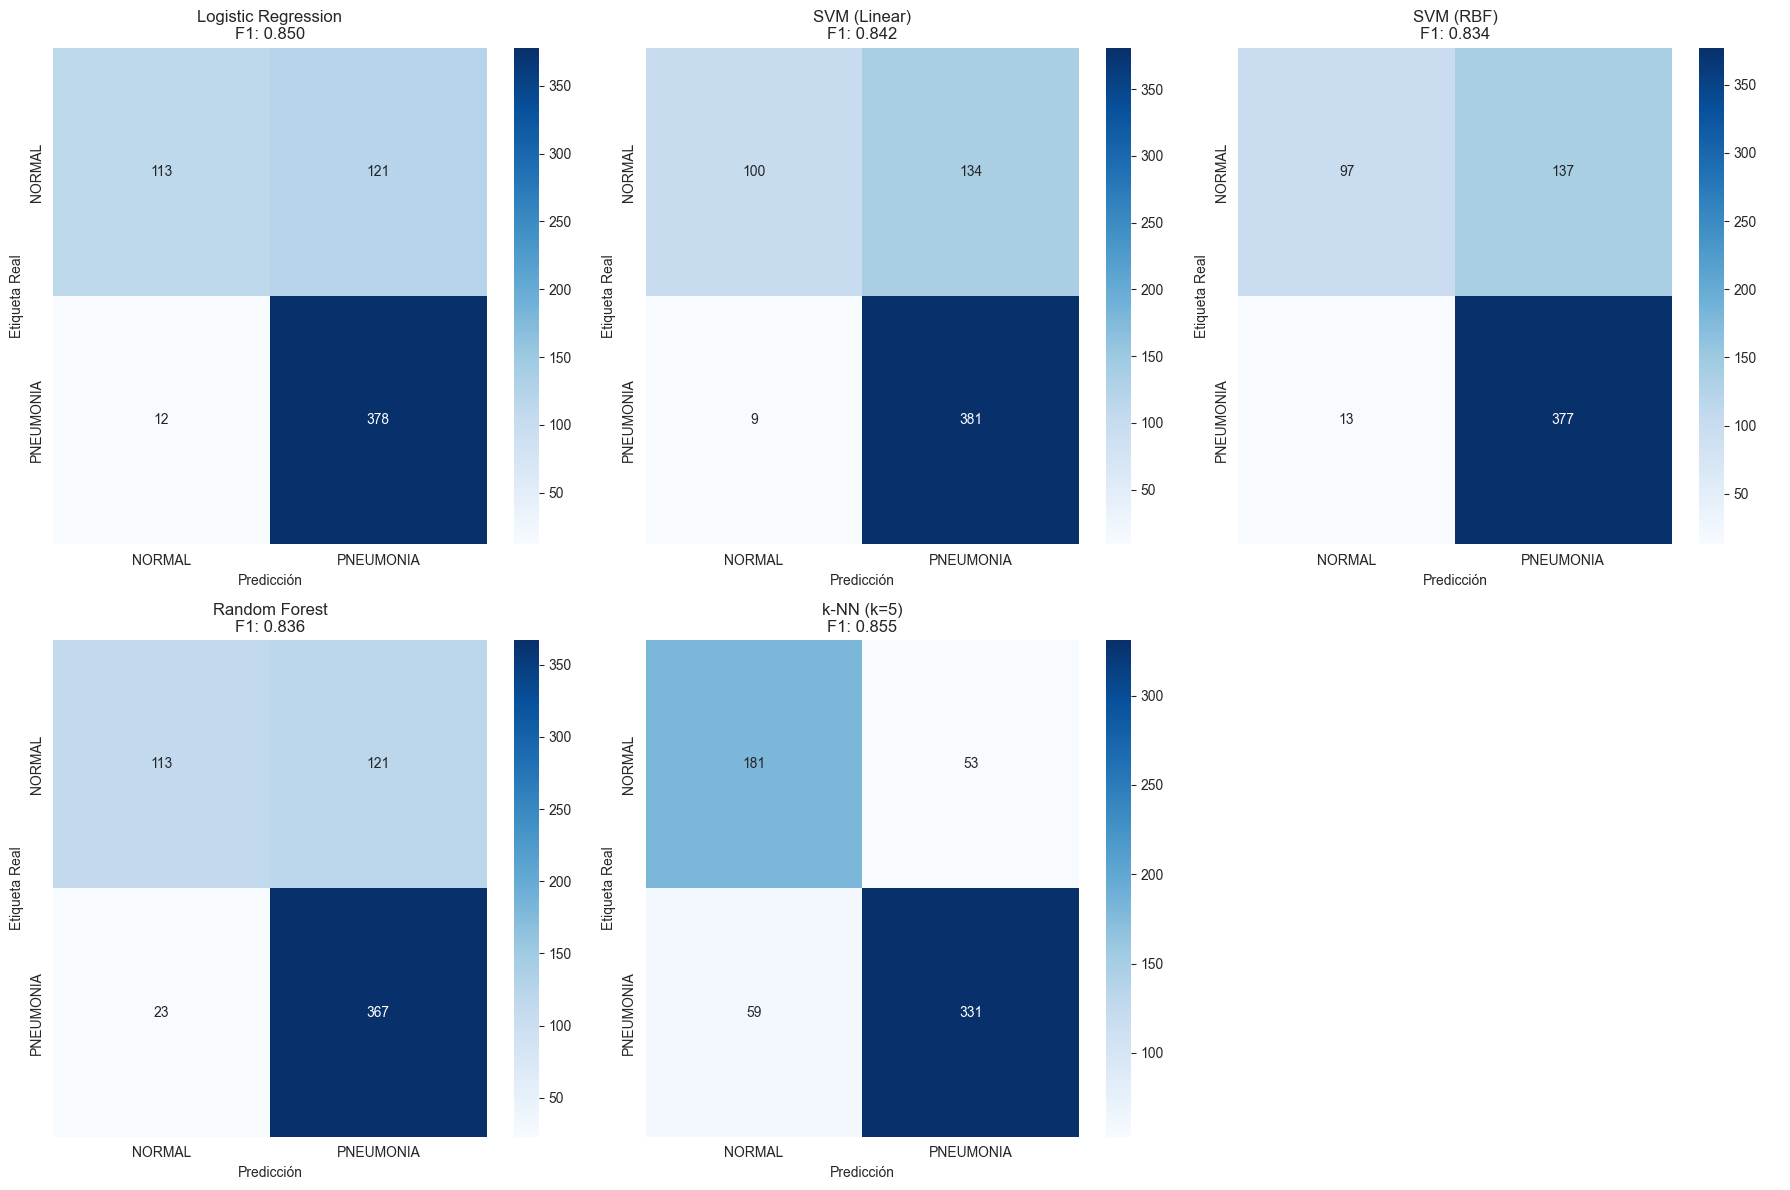

✅ Imagen guardada: results/figures/13_confusion_matrices.png

=== ANÁLISIS DETALLADO: k-NN (k=5) ===
              precision    recall  f1-score   support

      NORMAL       0.75      0.77      0.76       234
   PNEUMONIA       0.86      0.85      0.86       390

    accuracy                           0.82       624
   macro avg       0.81      0.81      0.81       624
weighted avg       0.82      0.82      0.82       624



In [ ]:
# Diccionario de etiquetas reales para cada modelo
# Los modelos clásicos comparten y_test
y_true_dict = {nombre: y_test for nombre in clasificadores.keys()}

# Para la CNN usamos su propio y_test_cnn
if 'nombre_cnn' in locals():
    y_true_dict[nombre_cnn] = y_test_cnn

# Lista de modelos a mostrar: todos los clásicos + (opcionalmente) la CNN
nombres_modelos = list(clasificadores.keys())
if 'nombre_cnn' in locals():
    nombres_modelos.append(nombre_cnn)

n_modelos = len(nombres_modelos)

# Visualizar matrices de confusión
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, nombre in enumerate(nombres_modelos):
    y_true = y_true_dict[nombre]
    y_pred = predicciones[nombre]
    
    cm = confusion_matrix(y_true, y_pred)
    
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        ax=axes[idx],
        xticklabels=['NORMAL', 'PNEUMONIA'],
        yticklabels=['NORMAL', 'PNEUMONIA']
    )
    
    # Buscar el F1 del modelo en df_metricas
    f1_val = df_metricas[df_metricas["Clasificador"] == nombre]["F1-Score"].values[0]
    
    axes[idx].set_title(f'{nombre}\nF1: {f1_val:.3f}')
    axes[idx].set_ylabel('Etiqueta Real')
    axes[idx].set_xlabel('Predicción')

# Si sobran subplots (por ejemplo, menos de 6 modelos), se ocultan
for j in range(n_modelos, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig('../results/figures/13_confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Imagen guardada: results/figures/13_confusion_matrices.png")

# Análisis detallado del mejor modelo
mejor_modelo = df_metricas.iloc[0]['Clasificador']
print(f"\n=== ANÁLISIS DETALLADO: {mejor_modelo} ===")

y_true_mejor = y_true_dict[mejor_modelo]
y_pred_mejor = predicciones[mejor_modelo]

print(classification_report(
    y_true_mejor,
    y_pred_mejor,
    target_names=['NORMAL', 'PNEUMONIA']
))

### 8. Curvas ROC
Visualizamos las curvas ROC para comparar el rendimiento de los clasificadores.

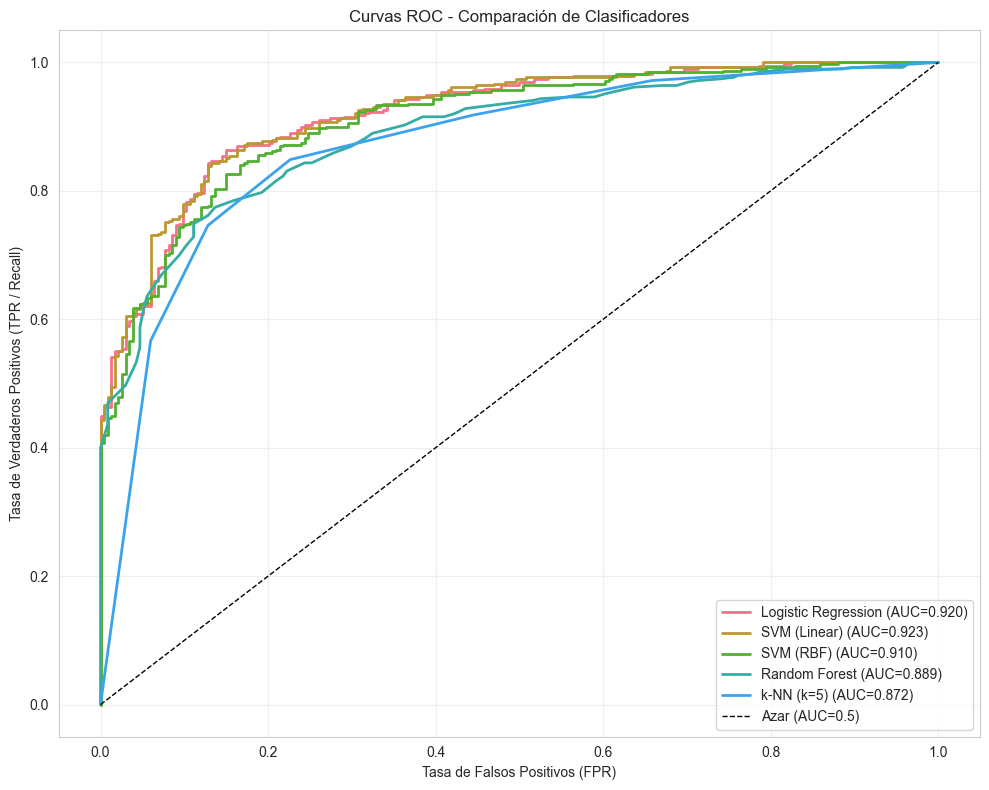

✅ Imagen guardada: results/figures/14_roc_curves.png


In [51]:
# Graficar curvas ROC
plt.figure(figsize=(10, 8))

for nombre in clasificadores.keys():
    if nombre in probabilidades:
        fpr, tpr, _ = roc_curve(y_test, probabilidades[nombre])
        auc = roc_auc_score(y_test, probabilidades[nombre])
        plt.plot(fpr, tpr, linewidth=2, label=f'{nombre} (AUC={auc:.3f})')

# Línea diagonal (clasificador aleatorio)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Azar (AUC=0.5)')

plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR / Recall)')
plt.title('Curvas ROC - Comparación de Clasificadores')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/figures/14_roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Imagen guardada: results/figures/14_roc_curves.png")

### 9. Análisis de Importancia de Características
Para Random Forest, analizamos qué características son más importantes.

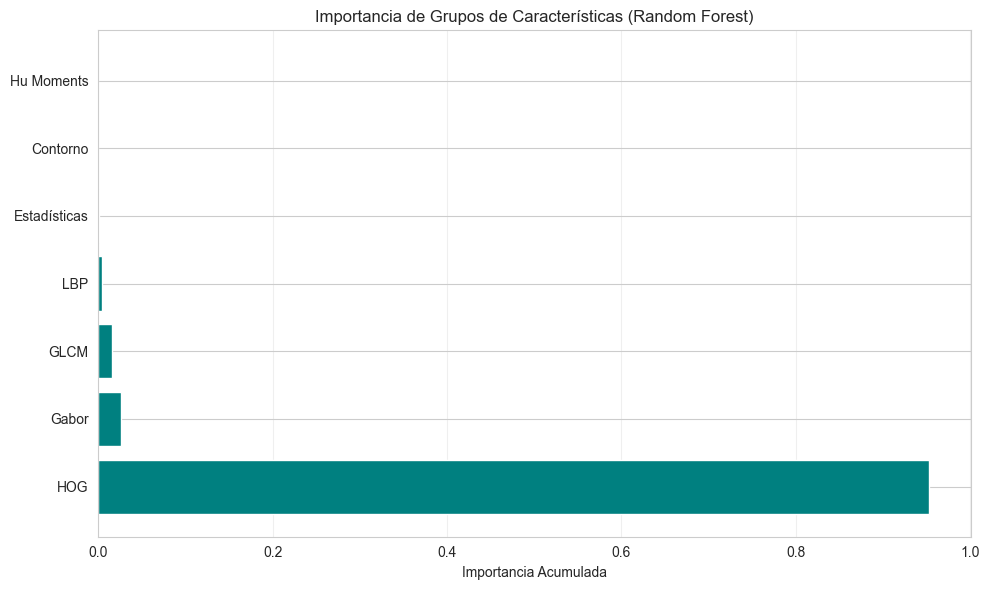


=== IMPORTANCIA DE CARACTERÍSTICAS (Random Forest) ===
HOG            : 0.9533
Gabor          : 0.0259
GLCM           : 0.0154
LBP            : 0.0043
Estadísticas   : 0.0011
Contorno       : 0.0001
Hu Moments     : 0.0000

✅ Imagen guardada: results/figures/15_feature_importance.png


In [52]:
# Importancia de características (Random Forest)
if 'Random Forest' in modelos_entrenados:
    rf_model = modelos_entrenados['Random Forest']
    importances = rf_model.feature_importances_
    
    # Nombres de características (simplificado)
    n_hog = 54756
    feature_names = (
        ['HOG'] * n_hog +
        ['Hu_1', 'Hu_2', 'Hu_3', 'Hu_4', 'Hu_5', 'Hu_6', 'Hu_7'] +
        ['Area', 'Perimetro', 'Circularidad', 'Excentricidad'] +
        ['LBP'] * 26 +
        ['GLCM_Contraste', 'GLCM_Disimilitud', 'GLCM_Homogeneidad', 'GLCM_Energia', 'GLCM_Correlacion'] +
        ['Gabor'] * 24 +
        ['Media', 'Varianza', 'Skewness', 'Kurtosis', 'Entropia']
    )
    
    # Agrupar importancias por tipo de descriptor
    grupos = {
        'HOG': importances[:n_hog].sum(),
        'Hu Moments': importances[n_hog:n_hog+7].sum(),
        'Contorno': importances[n_hog+7:n_hog+11].sum(),
        'LBP': importances[n_hog+11:n_hog+37].sum(),
        'GLCM': importances[n_hog+37:n_hog+42].sum(),
        'Gabor': importances[n_hog+42:n_hog+66].sum(),
        'Estadísticas': importances[n_hog+66:].sum(),
    }
    
    # Visualizar
    plt.figure(figsize=(10, 6))
    grupos_sorted = dict(sorted(grupos.items(), key=lambda x: x[1], reverse=True))
    plt.barh(list(grupos_sorted.keys()), list(grupos_sorted.values()), color='teal')
    plt.xlabel('Importancia Acumulada')
    plt.title('Importancia de Grupos de Características (Random Forest)')
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.savefig('../results/figures/15_feature_importance.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n=== IMPORTANCIA DE CARACTERÍSTICAS (Random Forest) ===")
    for grupo, imp in grupos_sorted.items():
        print(f"{grupo:15s}: {imp:.4f}")
    print("\n✅ Imagen guardada: results/figures/15_feature_importance.png")

### 10. Optimización de Hiperparámetros (Mejor Modelo)
Usamos GridSearchCV para optimizar el mejor clasificador.

In [53]:
# Optimización del mejor modelo (ejemplo con Random Forest)
print("\n=== OPTIMIZACIÓN DE HIPERPARÁMETROS ===")
print(f"Modelo seleccionado: {mejor_modelo}\n")

if 'Random Forest' in mejor_modelo:
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    grid_search = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid,
        cv=3,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )
    
    print("Ejecutando Grid Search...")
    grid_search.fit(X_train_scaled, y_train)
    
    print(f"\nMejores parámetros: {grid_search.best_params_}")
    print(f"Mejor F1-Score (CV): {grid_search.best_score_:.4f}")
    
    # Evaluar en test
    best_rf = grid_search.best_estimator_
    y_pred_optimized = best_rf.predict(X_test_scaled)
    
    print(f"\n=== RESULTADO OPTIMIZADO EN TEST ===")
    print(classification_report(y_test, y_pred_optimized, target_names=['NORMAL', 'PNEUMONIA']))

elif 'SVM' in mejor_modelo:
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.001, 0.01]
    }
    
    grid_search = GridSearchCV(
        SVC(kernel='rbf', probability=True, random_state=42),
        param_grid,
        cv=3,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )
    
    print("Ejecutando Grid Search...")
    grid_search.fit(X_train_scaled, y_train)
    
    print(f"\nMejores parámetros: {grid_search.best_params_}")
    print(f"Mejor F1-Score (CV): {grid_search.best_score_:.4f}")
    
    # Evaluar en test
    best_svm = grid_search.best_estimator_
    y_pred_optimized = best_svm.predict(X_test_scaled)
    
    print(f"\n=== RESULTADO OPTIMIZADO EN TEST ===")
    print(classification_report(y_test, y_pred_optimized, target_names=['NORMAL', 'PNEUMONIA']))


=== OPTIMIZACIÓN DE HIPERPARÁMETROS ===
Modelo seleccionado: k-NN (k=5)



### 11. Resumen Final y Conclusiones

In [54]:
print("\n" + "="*70)
print("RESUMEN FINAL - CLASIFICACIÓN CON DESCRIPTORES CLÁSICOS")
print("="*70)

print("\n1. DATASET:")
print(f"   - Entrenamiento: {len(y_train)} imágenes")
print(f"   - Prueba: {len(y_test)} imágenes")
print(f"   - Validación: {len(y_val)} imágenes")
print(f"   - Desbalance: {(y_train==1).sum()/(y_train==0).sum():.2f}:1 (Pneumonia:Normal)")

print("\n2. DESCRIPTORES IMPLEMENTADOS:")
print("   Forma:")
print("   ✓ HOG (Histogram of Oriented Gradients)")
print("   ✓ Momentos de Hu (7 invariantes)")
print("   ✓ Descriptores de Contorno (área, perímetro, circularidad, excentricidad)")
print("   \n   Textura:")
print("   ✓ LBP (Local Binary Patterns)")
print("   ✓ GLCM (Gray Level Co-occurrence Matrix)")
print("   ✓ Filtros de Gabor")
print("   ✓ Estadísticas de Primer Orden")

print("\n3. MEJORES RESULTADOS:")
print(df_metricas.head(3).to_string(index=False))

print("\n4. ANÁLISIS:")
print("   - El recall es crítico: no queremos falsos negativos (no detectar neumonía)")
print("   - El desbalance requiere métricas robustas (F1, Recall > Accuracy)")
print("   - Las curvas ROC muestran capacidad discriminativa de cada modelo")

print("\n" + "="*70)
print("✅ CLASIFICACIÓN CON DESCRIPTORES CLÁSICOS COMPLETADA")
print("="*70)


RESUMEN FINAL - CLASIFICACIÓN CON DESCRIPTORES CLÁSICOS

1. DATASET:
   - Entrenamiento: 1000 imágenes
   - Prueba: 624 imágenes
   - Validación: 16 imágenes
   - Desbalance: 1.00:1 (Pneumonia:Normal)

2. DESCRIPTORES IMPLEMENTADOS:
   Forma:
   ✓ HOG (Histogram of Oriented Gradients)
   ✓ Momentos de Hu (7 invariantes)
   ✓ Descriptores de Contorno (área, perímetro, circularidad, excentricidad)
   
   Textura:
   ✓ LBP (Local Binary Patterns)
   ✓ GLCM (Gray Level Co-occurrence Matrix)
   ✓ Filtros de Gabor
   ✓ Estadísticas de Primer Orden

3. MEJORES RESULTADOS:
       Clasificador  Accuracy  Precision   Recall  F1-Score  AUC-ROC
         k-NN (k=5)  0.820513   0.861979 0.848718  0.855297 0.871691
Logistic Regression  0.786859   0.757515 0.969231  0.850394 0.920064
       SVM (Linear)  0.770833   0.739806 0.976923  0.841989 0.922617

4. ANÁLISIS:
   - El recall es crítico: no queremos falsos negativos (no detectar neumonía)
   - El desbalance requiere métricas robustas (F1, Recall 